# Take a look at NDVI for Vancouver on Aug 11, 2016 

* NDVI is defined as (red - nearir)/(red + nearir) -- where red is first channel and nearir is the second channel for MODIS.  See [Wikipedia on NDVI](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index)

* [Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php)

* Band 1 centered at 0.645 microns (red), band 2 centered at 0.86 microns (near IR)

* data acquired at 250 m resolution, resampled to 1 km for the MYD021KM file

In [1]:
from e582utils.data_read import download
import numpy as np
import h5py
import sys
import warnings
from matplotlib import pyplot as plt
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)


MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite



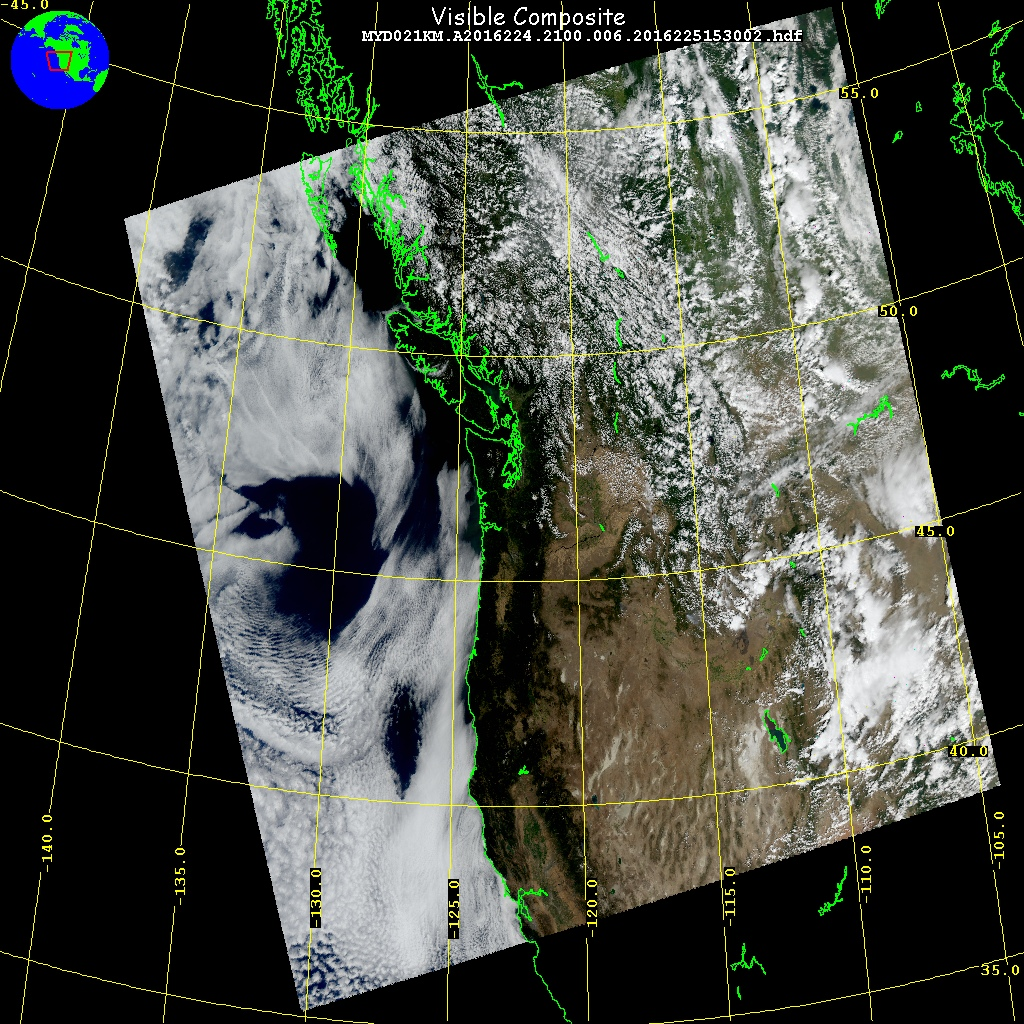

In [2]:
Image('figures/MYBRGB.A2016224.2100.006.2016237025650.jpg')

In [3]:
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)


MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



### Calibrate and resample the channel 1 and channel 2 reflectivities



In [4]:
from e582lib.modis_reproject import modisl1b_resample, write_h5
from e582lib.modis_reproject import make_projectname
chan_list=['1','2']
result_dict=\
       modisl1b_resample(myd02file,myd03file,chan_list)

index and mean 0 0.19366274774074554
index and mean 1 0.26666542887687683
running modisl1b_resample: here are the channels to be resampled
channel and mean 1 0.22162874042987823
channel and mean 2 0.28879809379577637
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '46.13', 'lon_0': '-122.60', 'proj': 'laea', 'units': 'm'}
Number of columns: 2222
Number of rows: 1943
Area extent: (-1280423.9837223424, -1189924.0707889115, 1609332.4889824667, 1336446.4037335052)


x and y pixel dimensions in meters:
1300.5204647636406
1300.2421381999056

completed modisl1b_resample


In [5]:
result_dict.keys()

dict_keys(['area_def_args', 'geotiff_args', 'channels', 'fill_value', 'basemap_args'])

### Write this resampled data out to hdf5 for future reuse

In [6]:
out_file=make_projectname(myd02file,chan_list)
print('ready to write {}'.format(out_file))
print('result_dict dictionary keys: '.format(result_dict.keys()))
print('remapped channel shape: ',result_dict['channels'].shape)
result_dict['out_file']=out_file
result_dict['in_file']=myd02file
result_dict['chan_list']=chan_list

write_h5(**result_dict)


ready to write MYD021KM.A2016224.2100.006.reproject.c_1_2.h5
result_dict dictionary keys: 
remapped channel shape:  (1943, 2222, 2)
hit:  (1943, 2222, 2)
here: --
{'ysize': 1943, 'area_id': 'granule', 'area_extent': [-1280423.9837223424, -1189924.0707889115, 1609332.4889824667, 1336446.4037335052], 'area_dict': {'datum': 'WGS84', 'lon_0': '-122.60', 'units': 'm', 'proj': 'laea', 'lat_0': '46.13'}, 'xsize': 2222, 'area_name': 'modis swath 5min granule', 'proj_id': 'laea'}--



### Now use the red and nearir channels to get the ndvi

In [7]:
ch1=result_dict['channels'][:,:,0]
ch2=result_dict['channels'][:,:,1]
ndvi = (ch2 - ch1)/(ch2 + ch1)

### check out the correlation using a 2-d histogram

In [8]:
from e582lib.geolocate import fast_hist, fast_count
ch1_min= 0.
ch1_max = 1.
num_ch1_bins=120

ch2_min = 0
ch2_max = 0.8
num_ch2_bins=100

ch1_hist = fast_hist(ch1.ravel(),ch1_min,ch1_max,numbins=num_ch1_bins)
ch2_hist =  fast_hist(ch2.ravel(),ch2_min,ch2_max,numbins=num_ch2_bins)
heatmap = fast_count(ch2_hist,ch1_hist)



### Why the strong correlation between channels 1 and 2?

Even the same surface can have very different reflectance values as the sun-satellite angle changes.  These changes due to geometry affect both channel 1 and channel 2 approximately equally.   That is why need to remove this spurious variability by creating the the "normalized" vegetation difference index.  By ratioing
(chan2 - chan1)/(chan2 + chan1) you remove much of the change due to geometry -- the difference between high and low reflectivities is smoothed, as long as it occurs in both channels.

Below we'll use the "perceptually uniform" magma colormap. For other colormap choices see:

http://matplotlib.org/users/colormaps.html

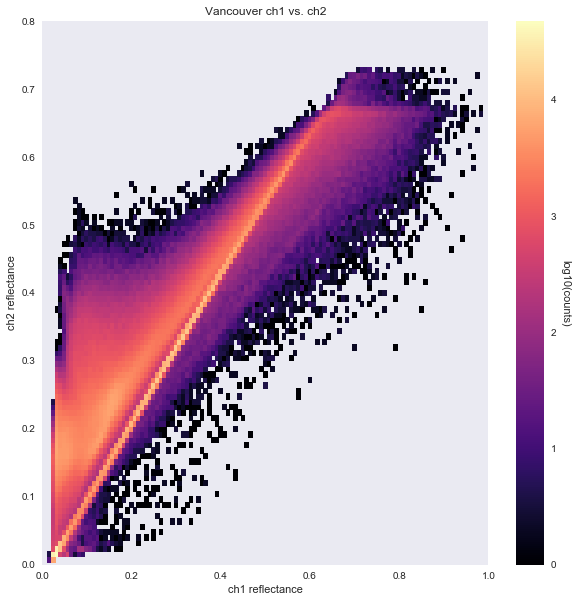

In [9]:

cmap=cm.get_cmap('magma')
with np.errstate(divide='ignore'): #use a context manager (with)
    log_counts=np.log10(heatmap)  #turn off divide by zero warning
masked_counts = np.ma.masked_invalid(log_counts)
fig, ax = plt.subplots(1,1,figsize=(10,10))
CS=ax.pcolormesh(ch1_hist['centers_vec'],ch2_hist['centers_vec'],masked_counts,cmap=cmap)
cax=fig.colorbar(CS,ax=ax)
ax.set(xlim=(0,1.),ylim=(0,0.8))
out=cax.ax.set_ylabel('log10(counts)')
out.set_rotation(270)
out.set_verticalalignment('bottom')
ax.set(xlabel='ch1 reflectance',ylabel='ch2 reflectance',
       title='Vancouver ch1 vs. ch2');



In [10]:
interactive=False
if interactive:
    sns.choose_diverging_palette(as_cmap=True);

In [11]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('c')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

{'orientation': 'horizontal', 'ticklocation': 'bottom'}


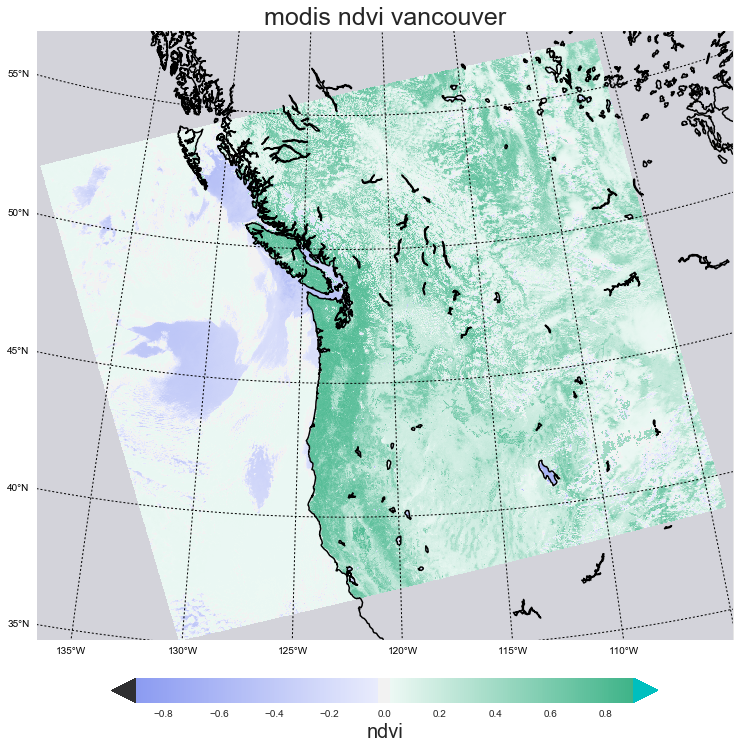

In [24]:
masked_ndvi = np.ma.masked_invalid(ndvi)
fig,ax=plt.subplots(1,1,figsize=(14,14))
basemap_args=result_dict['basemap_args']
basemap_args['ax']=ax
basemap_args['resolution']='i'
bmap=Basemap(**basemap_args)
lat_sep,lon_sep= 5,5
parallels = np.arange(30, 60, lat_sep)
meridians = np.arange(-135, -100, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                       fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90)
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='k')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    col = bmap.imshow(masked_ndvi,origin='upper', norm=the_norm,cmap=cmap)
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=fig.colorbar(col,cax=cax,extend='both',**kw)
    out.set_label('ndvi',size=20)
    ax.set_title('modis ndvi vancouver',size=25)
    print(kw)

### can save some time by reusing the bmap instance with a new axis

{'orientation': 'horizontal', 'ticklocation': 'bottom'}


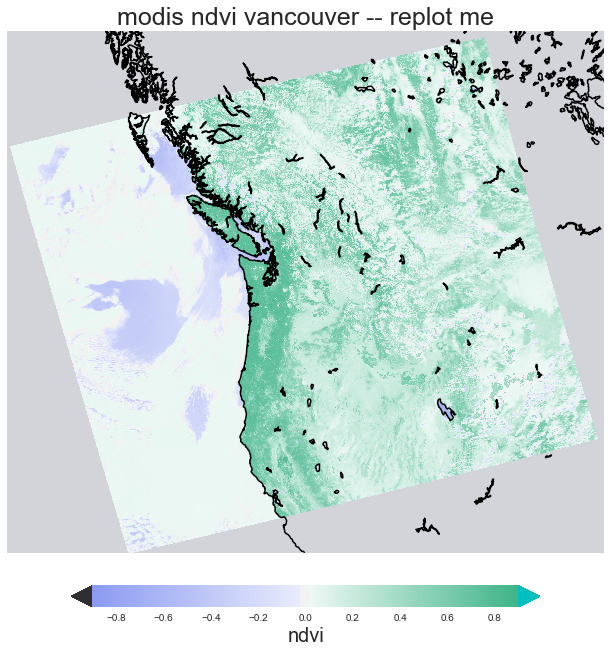

In [26]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
bmap.ax=ax
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    col = bmap.imshow(masked_ndvi,origin='upper', norm=the_norm,cmap=cmap)
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=fig.colorbar(col,cax=cax,extend='both',**kw)
    out.set_label('ndvi',size=20)
    ax.set_title('modis ndvi vancouver -- replot me   ',size=25)
    print(kw)
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='k');